<a href="https://colab.research.google.com/github/VictorAlexandr/Formacao-Machine-Learning-Specialist/blob/main/Projeto_de_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# Carregar o dataset com o TensorFlow Datasets
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="cats_vs_dogs",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

IMG_SIZE = 150  # Definir o tamanho da imagem para redimensionamento

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalizar os valores dos pixels
    return image, label

# Pré-processamento dos dados
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.IP7VVZ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
BATCH_SIZE = 64  # Definir um tamanho de lote adequado
SHUFFLE_BUFFER_SIZE = 1000

# Usando um subset dos dados para testes rápidos
train_subset = train.take(2000)
validation_subset = validation.take(1000)

train_batches = train_subset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation_subset.batch(BATCH_SIZE)

In [4]:
# Carregar o modelo pré-treinado
pre_trained_model = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                include_top=False,
                                weights='imagenet')

# Congelar as camadas do modelo pré-treinado
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [5]:
# Construir o modelo
model = models.Sequential([
    pre_trained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 23901985 (91.18 MB)
Trainable params: 2099201 (8.01 MB)
Non-trainable params: 21802784 (83.17 MB)
__________

In [6]:
# Checkpoints e early stopping
checkpoint_cb = ModelCheckpoint("cats_and_dogs_classifier.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Treinamento do modelo
history = model.fit(
    train_batches,
    epochs=5,  # Ajustar o número de épocas para testes rápidos
    validation_data=validation_batches,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 - 14s - loss: 0.3108 - accuracy: 0.9020 - val_loss: 0.1120 - val_accuracy: 0.9570 - 14s/epoch - 449ms/step
Epoch 2/5
32/32 - 8s - loss: 0.1165 - accuracy: 0.9525 - val_loss: 0.1145 - val_accuracy: 0.9570 - 8s/epoch - 247ms/step
Epoch 3/5
32/32 - 8s - loss: 0.0652 - accuracy: 0.9760 - val_loss: 0.1514 - val_accuracy: 0.9520 - 8s/epoch - 241ms/step
Epoch 4/5
32/32 - 8s - loss: 0.0566 - accuracy: 0.9780 - val_loss: 0.1370 - val_accuracy: 0.9610 - 8s/epoch - 245ms/step
Epoch 5/5
32/32 - 9s - loss: 0.0503 - accuracy: 0.9780 - val_loss: 0.1090 - val_accuracy: 0.9680 - 9s/epoch - 266ms/step


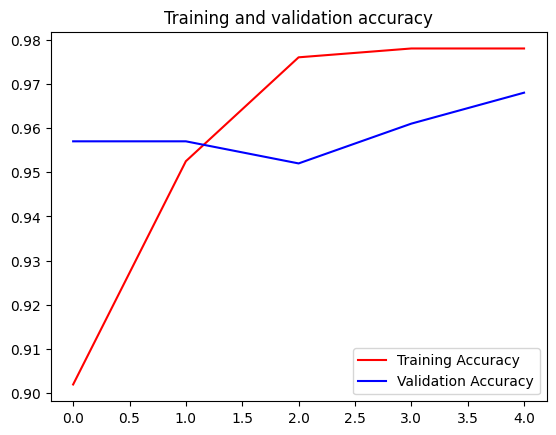

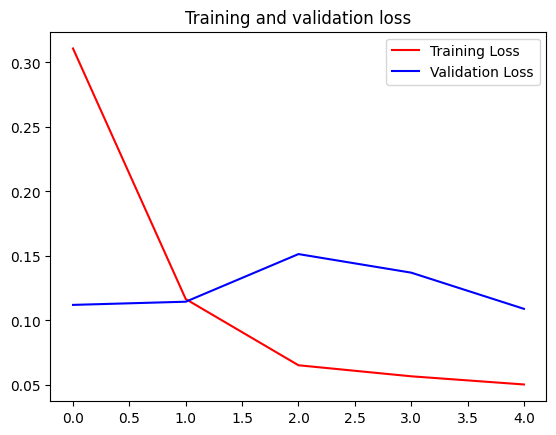

In [7]:
# Plotar gráficos de treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc="lower right")
plt.figure()

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.legend(loc="upper right")
plt.show()

In [8]:
# Salvando o modelo final
model.save("final_cats_and_dogs_classifier.h5")